# **Modeling**
---

In [1]:
#Import of the relevant libaries
import numpy as np
import matplotlib.pyplot as plt 
import time
import pickle
import tensorflow as tf   
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2, Xception, NASNetMobile, InceptionResNetV2
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adagrad
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score
from tensorboard.plugins.hparams import api as hp
from google.colab import files, drive
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow. keras.utils import to_categorical 
#from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Table of Conents**
---
[Preprocess Data](#preprocess)<br>
[MobileNetV2](#mobile)<br>
[Xception](#xception)<br>
[Evaluation](#Evaluation)<br>

In [ ]:
image_size = (224, 224)
batch_size = 32
epochs=50
num_classes = 4

In [ ]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 6,
                                                 verbose = 1,
                                                 restore_best_weights = True)

## Preprocess Data
<a id='preprocess'></a>

In [ ]:
#This is only necessary when you use google.colab and the trainingsdata are stored in google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x_test = pickle.load(open("/content/drive/MyDrive/data/x_test.pickle", "rb"))
y_test = pickle.load(open("/content/drive/MyDrive/data/y_test.pickle", "rb"))

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        brightness_range = (0.4, 0.6),
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input
        )

train_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/Images/Train',
        target_size=image_size,
        color_mode='rgb',
        classes = ["Tel-Aviv","WestJerusalem" ,"Berlin", "Hamburg"],
        batch_size=batch_size,
        shuffle = True,
        seed = 777,
        #save_to_dir = '/content/fotos',
        #save_format='png', 
        follow_links=True,
        subset = 'training',
        class_mode='categorical')

validation_generator  = datagen.flow_from_directory(
        '/content/drive/MyDrive/Images/Train',
        target_size=image_size,
        color_mode='rgb',
        classes = ["Tel-Aviv","WestJerusalem" ,"Berlin", "Hamburg"],
        batch_size=batch_size,
        shuffle = True,
        seed = 777,
        #save_to_dir = '/content/fotos',
        #save_format='png', 
        follow_links=True,
        subset = 'validation',
        class_mode='categorical')

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## MobileNetV2
<a id='mobile'></a>

### Instantiating the model
<a id='Instantiating'></a>

In [ ]:
NAME = "mobilenetv2-{}".format(int(time.time()))
tensorboard_mnv2 = TensorBoard(log_dir='logs/{}'.format(NAME))

In [ ]:
def create_model_mnv2(input_shape, num_classes= 4):
    input_tensor = Input(shape=input_shape)
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling='avg',
        alpha=1.0)

    # Fine-tune from this layer onwards
    fine_tune_at = 100


    base_model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False 
        
    #op = Dense(256, activation='elu')(base_model.output)
    op = Dropout(.25)(base_model.output)
    
    ##
    # sigmoid: calculates a probability for the class.
    ##
    output_tensor = Dense(num_classes, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)


    return model

In [ ]:
model_mnv2 = create_model_mnv2(input_shape = image_size+(3,), num_classes=num_classes)
model_mnv2.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


### Model fitting
<a id='Fitting'></a>

In [ ]:
history_mnv2  = model_mnv2.fit(train_generator, batch_size=batch_size, use_multiprocessing=True, workers=8 , epochs=epochs, validation_data = validation_generator , callbacks=[early_stopper, reduce_lr, tensorboard_mnv2])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
300/300 [==============================] - 403s 1s/step - loss: 0.6729 - accuracy: 0.7093 - val_loss: 9.4811 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - 98s 319ms/step - loss: 0.4524 - accuracy: 0.8102 - val_loss: 9.3130 - val_accuracy: 0.3108 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - 100s 322ms/step - loss: 0.3750 - accuracy: 0.8411 - val_loss: 6.2997 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - 99s 323ms/step - loss: 0.3365 - accuracy: 0.8669 - val_loss: 1.7629 - val_accuracy: 0.5575 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - 99s 322ms/step - loss: 0.2937 - accuracy: 0.8832 - val_loss: 4.0201 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - 119s 388ms/step - loss: 0.2459 - accuracy: 0.9073 - val_loss: 2.0275 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 7/50
300/300 [==============================] 

### Check the model

In [ ]:
model_mnv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Xception
<a id='xception'></a>

### Instantiating the model

In [ ]:
NAME = "xception-{}".format(int(time.time()))
tensorboard_x = TensorBoard(log_dir='logs/{}'.format(NAME))

In [ ]:
def create_model_x(input_shape, num_classes= 4):
    input_tensor = Input(shape=input_shape)
    base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling='avg')

    base_model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:25]:
        layer.trainable =  False

    #op = MaxPooling2D()(base_model.output)    
    op = Dense(256, activation='elu')(base_model.output)
    op = Dropout(.25)(op)
    
    ##
    # sigmoid: calculates a probability for the class.
    ##
    output_tensor = Dense(units=num_classes, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)


    return model

In [ ]:
model_x = create_model_x(input_shape = image_size+(3,), num_classes=num_classes)
model_x.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

83697664/83683744 [==============================] - 1s 0us/step


### Model fitting

In [ ]:
history_x= model_x.fit(train_generator, batch_size=batch_size, use_multiprocessing=True, workers=4, epochs=epochs, validation_data = validation_generator , callbacks=[early_stopper, reduce_lr,tensorboard_x ])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
300/300 [==============================] - 117s 364ms/step - loss: 0.6705 - accuracy: 0.7157 - val_loss: 2.2617 - val_accuracy: 0.5775 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - 112s 367ms/step - loss: 0.4273 - accuracy: 0.8261 - val_loss: 0.7085 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - 111s 365ms/step - loss: 0.3462 - accuracy: 0.8582 - val_loss: 0.9675 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - 111s 366ms/step - loss: 0.2863 - accuracy: 0.8896 - val_loss: 0.6747 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - 110s 363ms/step - loss: 0.2408 - accuracy: 0.9126 - val_loss: 0.4967 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - 110s 362ms/step - loss: 0.2096 - accuracy: 0.9199 - val_loss: 0.5247 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 7/50
300/300 [==========================

### Check the model

In [ ]:
model_x.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

## Model evaluation
<a id='Evaluation'></a>

### Functions:

In [ ]:
def history_plot(history):
  acc_cnn = history.history['accuracy']
  val_acc_cnn = history.history['val_accuracy']

  loss_cnn = history.history['loss']
  val_loss_cnn = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc_cnn, label='Training Accuracy')
  plt.plot(val_acc_cnn, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss_cnn, label='Training Loss')
  plt.plot(val_loss_cnn, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def eval_metrics(y, y_pred_train):
  y_classes = np.argmax(y, axis=1)
  pred_classes = np.argmax(y_pred_train, axis=1)

  print(confusion_matrix(y_classes, pred_classes))
  print(classification_report(y_classes, pred_classes))
  print(accuracy_score(y_classes, pred_classes))

In [ ]:
    #Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. 
    #A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), 
    #whereas a micro-average will aggregate the contributions of all classes to compute the average metric. 
    #In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

def auc_score(y, y_pred, classes = 4):
  lw = 2
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(classes):
   fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
   roc_auc[i] = auc(fpr[i], tpr[i])
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(classes):
   mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
  mean_tpr /= 4
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  plt.figure()
  plt.plot(
        fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )
  plt.plot(
        fpr["macro"],
      tpr["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(4), colors):
        plt.plot(
            fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )
  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()
  macro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo", average="macro")
  weighted_roc_auc_ovo = roc_auc_score(
        y_test, y_pred, multi_class="ovo", average="weighted"
  )
  macro_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr", average="macro")
  weighted_roc_auc_ovr = roc_auc_score(
        y_test, y_pred, multi_class="ovr", average="weighted"
  )
  print(
        "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
  )
  print(
        "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
  )
  micro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo", average="micro")
  weighted_roc_auc_ovo = roc_auc_score(
        y_test, y_pred, multi_class="ovo", average="weighted"
  )
  micro_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr", average="micro")
  weighted_roc_auc_ovr = roc_auc_score(
        y_test, y_pred, multi_class="ovr", average="weighted"
  )
  print(
          "One-vs-One ROC AUC scores:\n{:.6f} (micro),\n{:.6f} "
        "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
    )
  print(
          "One-vs-Rest ROC AUC scores:\n{:.6f} (micro),\n{:.6f} "
        "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
    )


### MobileNetV2
<a id='Fitting'></a>

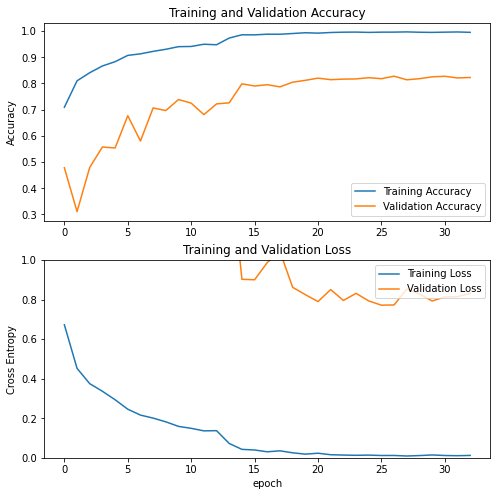

In [ ]:
history_plot(history_mnv2)

In [ ]:
y_pred_train_mnv2 = model_mnv2.evaluate(train_generator, batch_size=batch_size, use_multiprocessing=True, workers=8 )

300/300 [==============================] - 76s 245ms/step - loss: 0.0047 - accuracy: 0.9985


In [ ]:
y_pred_train_mnv2 = model_mnv2.evaluate(validation_generator, batch_size=batch_size, use_multiprocessing=True, workers=8 )


75/75 [==============================] - 20s 226ms/step - loss: 0.8303 - accuracy: 0.8142


In [ ]:
start = time.time()
y_pred_test_mnv2 = model_mnv2.predict(x_test)
end = time.time()

In [ ]:
print("time - {}".format(end-start))

time - 7.065512180328369


In [ ]:
eval_metrics(y_test, y_pred_test_mnv2)

[[672  53  17   9]
 [ 92 641  10   7]
 [  2   0 643 105]
 [  4   5  70 671]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       751
           1       0.92      0.85      0.88       750
           2       0.87      0.86      0.86       750
           3       0.85      0.89      0.87       750

    accuracy                           0.88      3001
   macro avg       0.88      0.88      0.88      3001
weighted avg       0.88      0.88      0.88      3001

0.8753748750416528


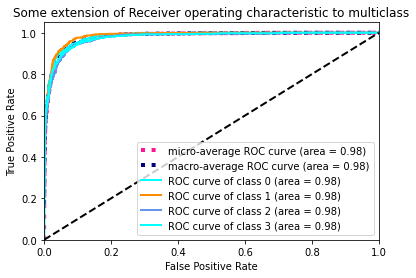

One-vs-One ROC AUC scores:
0.980149 (macro),
0.980150 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.980149 (macro),
0.980150 (weighted by prevalence)
One-vs-One ROC AUC scores:
0.980149 (micro),
0.980150 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.980149 (micro),
0.980150 (weighted by prevalence)


In [ ]:
auc_score(y_test, y_pred_test_mnv2)

### Xception

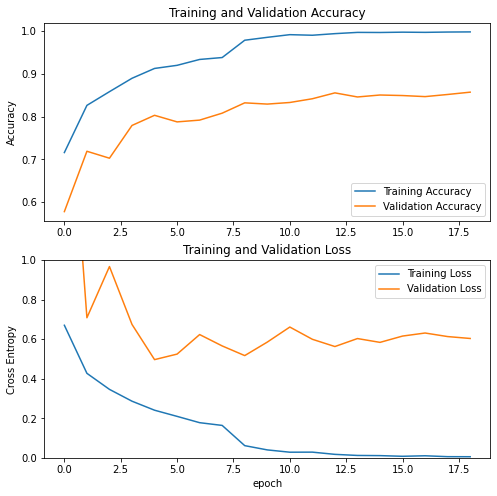

In [ ]:
history_plot(history_x)

In [ ]:
y_pred_train_x = model_x.evaluate(train_generator, use_multiprocessing=True, workers=8)
y_pred_val_x = model_x.evaluate(validation_generator, use_multiprocessing=True, workers=8)
start = time.time()
y_pred_test_x = model_x.predict(x_test)
end = time.time()

75/75 [==============================] - 21s 240ms/step - loss: 0.5673 - accuracy: 0.8562


In [ ]:
print(end - start )

11.785536289215088


In [ ]:
eval_metrics(y_test, y_pred_test_x)

[[685  49  12   5]
 [ 68 673   5   4]
 [  3   4 680  63]
 [  3   1  94 652]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       751
           1       0.93      0.90      0.91       750
           2       0.86      0.91      0.88       750
           3       0.90      0.87      0.88       750

    accuracy                           0.90      3001
   macro avg       0.90      0.90      0.90      3001
weighted avg       0.90      0.90      0.90      3001

0.8963678773742086


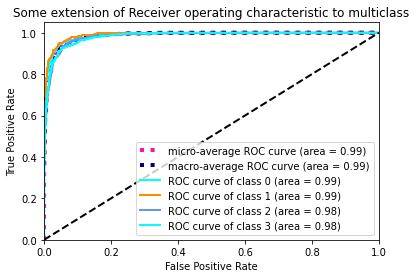

One-vs-One ROC AUC scores:
0.986381 (macro),
0.986382 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.986381 (macro),
0.986382 (weighted by prevalence)
One-vs-One ROC AUC scores:
0.986381 (micro),
0.986382 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.986381 (micro),
0.986382 (weighted by prevalence)


In [ ]:
auc_score(y_test, y_pred_test_x)

##Save Models

In [ ]:
model_mnv2.save('/content/drive/MyDrive/Models/model_mnv_final.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/model_mnv_final.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model_x.save('/content/drive/MyDrive/Models/model_x_final.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/model_x_final.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
